In [25]:
import pandas as pd
import numpy as np
import itertools
import copy

from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, ConfusionMatrixDisplay, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [3]:
#Load training dataset, remove missing values in Y, create X and Y matrices.

df_train = pd.read_csv('data/train.csv')

df_train.dropna(subset=['Y'], inplace=True)

X = df_train.drop('Y', axis = 1)
y = df_train[['Y']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, test_size=0.2, shuffle=True, random_state=0
)

#Load test predictors

X_test_real = pd.read_csv('data/Xtest.csv')

## Pipeline for models

In [4]:
class Std(TransformerMixin):
    
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        mean_X = np.mean(X, axis=0)
        std_X = np.std(X, axis=0)
        X = X[(abs(X - mean_X) < 4 * std_X).all(axis=1)]
        return X


def preprocessing(sub, X_train_sub, X_test_sub):
    numeric_features = copy.copy(sub)
    categorical_features = list()
    if "X11" in sub:
        numeric_features.remove("X11")
        categorical_features.append("X11")
    if "X12" in sub:
        numeric_features.remove("X12")
        categorical_features.append("X12")

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), # mean, median, most_frequent
        ('std', Std()),
        ('scaler', StandardScaler())], verbose=True)

    if len(categorical_features) > 1:
        X_train_sub = X_train_sub.astype({'X11':'category', 'X12':'category'})
        X_test_sub = X_test_sub.astype({'X11':'category', 'X12':'category'})
    elif len(categorical_features) == 1:
        if categorical_features[0] == "X11":
            X_train_sub = X_train_sub.astype({'X11':'category'})
            X_test_sub = X_test_sub.astype({'X11':'category'})
        else:
            X_train_sub = X_train_sub.astype({'X12':'category'})
            X_test_sub = X_test_sub.astype({'X12':'category'})

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # obligatoire
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))], verbose=True) #Same as pd.get_dummies 

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    
    return preprocessor, X_train_sub, X_test_sub

### Code générique pour construire notre model.

In [5]:
## Fit all models 
sub = ["X1", "X6", "X10", "X11", "X12"]
X_train_sub  = X_train
X_test_sub = X_test

preprocessor, X_train_sub, X_test_sub = preprocessing(sub, X_train_sub, X_test_sub)


class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return np.asarray(X.todense())

Regardons quel est le meilleur classifieur entre kNN, logistic Regression, Random forest, Grandient Boosting et High grandient Boosting

In [27]:
Model = {"kNN" : KNeighborsClassifier(n_neighbors=100, weights="distance", p=1), 
         "Lr" : LogisticRegression(max_iter=1000, penalty="l2", C = 1000, fit_intercept=True),
         "Rf" : ExtraTreesClassifier(n_estimators=5000, criterion='entropy', max_depth=400, min_samples_leaf=1, min_samples_split=2),
         "Naive Bayes" : GaussianNB(),
         "Gradient Boost" :GradientBoostingClassifier(loss="log_loss", learning_rate=0.02, n_estimators=420, criterion="squared_error", max_depth=None, validation_fraction=0.2, n_iter_no_change=5, tol =1e-4),
         "Hgb" : HistGradientBoostingClassifier(loss='log_loss',  learning_rate=0.02, max_iter=420, max_leaf_nodes=None,min_samples_leaf=20, l2_regularization=1, validation_fraction=0.2, n_iter_no_change=5, tol=1e-4)
         }

for model_name, model in Model.items():
    Pipe = Pipeline(steps = [("preprocessor", preprocessor),
                             ('to_dense', DenseTransformer()),
                             ('pca', PCA(n_components=0.965, random_state=42, svd_solver='full', n_oversamples=100)),
                             ('classifier', model)], verbose=True)
    Pipe.fit(X_train_sub, y_train.values.ravel())
    Model[model_name] = Pipe
    print(f"Le model {model_name} est fitted")

[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.0s
[Pipeline] ............ (step 3 of 3) Processing scaler, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing onehot, total=   0.0s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   0.1s
[Pipeline] .......... (step 2 of 4) Processing to_dense, total=   0.0s
[Pipeline] ............... (step 3 of 4) Processing pca, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.0s
Le model kNN est fitted
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.0s
[Pipeline] ............ (step 3 of 3) Processing scaler, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing oneh

C:\Users\jerom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[Pipeline] ........ (step 4 of 4) Processing classifier, total=   5.8s
Le model Lr est fitted
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.0s
[Pipeline] ............ (step 3 of 3) Processing scaler, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing onehot, total=   0.0s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   0.0s
[Pipeline] .......... (step 2 of 4) Processing to_dense, total=   0.0s
[Pipeline] ............... (step 3 of 4) Processing pca, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 2.2min
Le model Rf est fitted
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.0s
[Pipeline] ............ (step 3 of 3) Processing scaler, total=   0.0s
[Pipeline] ........... (step 1 

Log loss of kNN: 0.4801376841881744
Accuracy of kNN is 0.8161683277962348


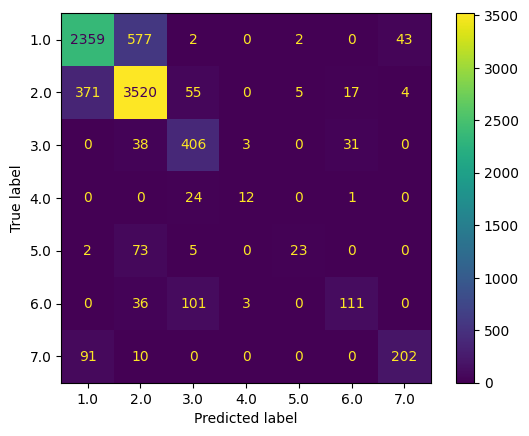

Log loss of Lr: 0.6681295684644323
Accuracy of Lr is 0.7061646363971945


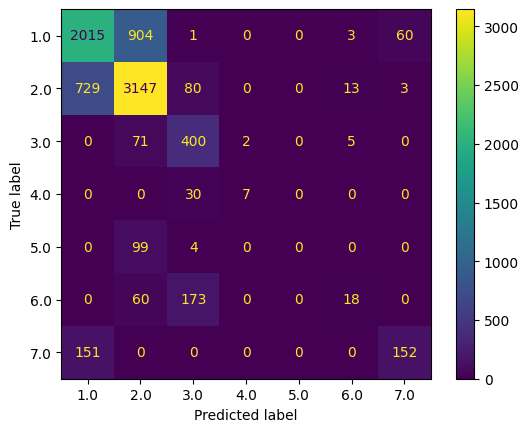

Log loss of Rf: 0.2866742797420343
Accuracy of Rf is 0.8943029408145687


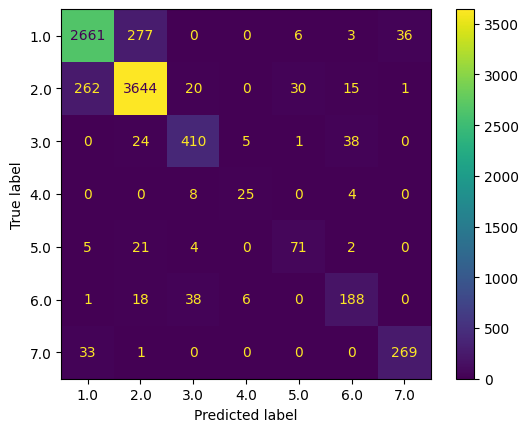

Log loss of Naive Bayes: 2.121346003129367
Accuracy of Naive Bayes is 0.5818875353759074


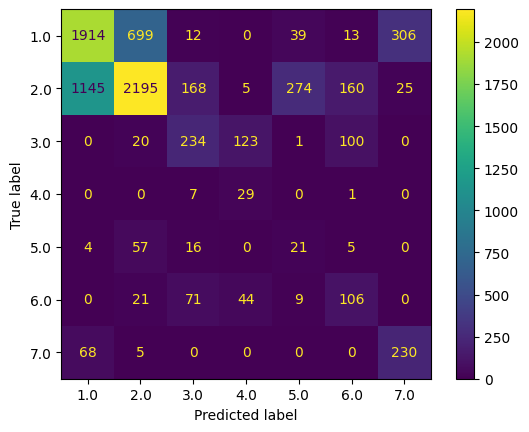

Log loss of Gradient Boost: 0.48120819835765677
Accuracy of Gradient Boost is 0.8544358311800172


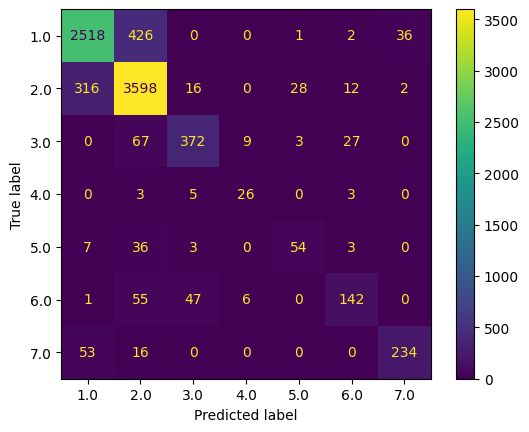

Log loss of Hgb: 0.3383486233380227
Accuracy of Hgb is 0.873015873015873


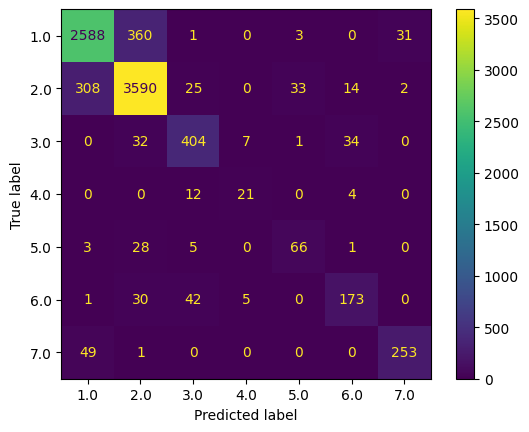

In [28]:
Resultats = []
for model_name, model in Model.items():
    pred_prob_train = pd.DataFrame(model.predict_proba(X_test_sub))
    loss = log_loss(y_test, pred_prob_train)
    print(f'Log loss of {model_name}: {loss}')

    y_pred = model.predict(X_test_sub)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {model_name} is {test_accuracy}")
    
    Resultats.append([loss, test_accuracy])

    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

In [29]:
result = pd.DataFrame(Resultats, columns=["Log_loss", "Test accuracy"], index=Model.keys())
result

,Log_loss,Test accuracy
kNN,0.480138,0.816168
Lr,0.668130,0.706165
Rf,0.286674,0.894303
Naive Bayes,2.121346,0.581888
Gradient Boost,0.481208,0.854436
Hgb,0.338349,0.873016


In [30]:
for model_name, model in Model.items():
    y_pred = model.predict(X_test_sub)
    print(f"Classification report of {model_name}\n", classification_report(y_test, y_pred))

Classification report of kNN
               precision    recall  f1-score   support

         1.0       0.84      0.79      0.81      2983
         2.0       0.83      0.89      0.86      3972
         3.0       0.68      0.85      0.76       478
         4.0       0.67      0.32      0.44        37
         5.0       0.77      0.22      0.35       103
         6.0       0.69      0.44      0.54       251
         7.0       0.81      0.67      0.73       303

    accuracy                           0.82      8127
   macro avg       0.76      0.60      0.64      8127
weighted avg       0.82      0.82      0.81      8127

Classification report of Lr
               precision    recall  f1-score   support

         1.0       0.70      0.68      0.69      2983
         2.0       0.74      0.79      0.76      3972
         3.0       0.58      0.84      0.69       478
         4.0       0.78      0.19      0.30        37
         5.0       0.00      0.00      0.00       103
         6.0       

C:\Users\jerom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jerom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jerom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334

Classification report of Rf
               precision    recall  f1-score   support

         1.0       0.90      0.89      0.90      2983
         2.0       0.91      0.92      0.92      3972
         3.0       0.85      0.86      0.86       478
         4.0       0.69      0.68      0.68        37
         5.0       0.66      0.69      0.67       103
         6.0       0.75      0.75      0.75       251
         7.0       0.88      0.89      0.88       303

    accuracy                           0.89      8127
   macro avg       0.81      0.81      0.81      8127
weighted avg       0.89      0.89      0.89      8127

Classification report of Naive Bayes
               precision    recall  f1-score   support

         1.0       0.61      0.64      0.63      2983
         2.0       0.73      0.55      0.63      3972
         3.0       0.46      0.49      0.47       478
         4.0       0.14      0.78      0.24        37
         5.0       0.06      0.20      0.09       103
         6.

https://askcodez.com/comment-ameliorer-randomforest-la-performance.html

https://stats.stackexchange.com/questions/53240/practical-questions-on-tuning-random-forests